<a href="https://colab.research.google.com/github/yun-k01/ADA-Project/blob/main/ADA_7325_Assn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CISC 351 Assignment 2
## Yun Kyaw, 20177325

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Change directory to MyDrive
import os
import imageio
import glob
import random
from collections import Counter
from google.colab.patches import cv2_imshow
os.chdir("/content/drive/MyDrive")
! unzip archive.zip

Mounted at /content/drive
Archive:  archive.zip


### Image Classification using C-NN
Creating a basic CNN model that can identify if an image is related to the following 13 subcategories: Topwear, Bottomwear, Innerwear, Bags, Watches, Jewellery, Eyewear, Wallets, Shoes, Sandal, Makeup, Fragrance, or Others. Specifically, the dataset contains 44,441 fashion product images.

In [ ]:
from google.colab.patches import cv2_imshow

<ipython-input-5-c268a70aa530>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pic = imageio.imread('./myntradataset/images/'+ random_pic_file)


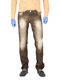

Streaming output truncated to the last 5000 lines.
11848: 1 (0.02%)
11849: 1 (0.02%)
11850: 1 (0.02%)
11851: 1 (0.02%)
11852: 1 (0.02%)
11853: 1 (0.02%)
11854: 1 (0.02%)
11855: 1 (0.02%)
11856: 1 (0.02%)
11857: 1 (0.02%)
11858: 1 (0.02%)
11859: 1 (0.02%)
11860: 1 (0.02%)
11861: 1 (0.02%)
11862: 1 (0.02%)
11863: 1 (0.02%)
11864: 1 (0.02%)
11865: 1 (0.02%)
11866: 1 (0.02%)
11867: 1 (0.02%)
11868: 1 (0.02%)
11869: 1 (0.02%)
11870: 1 (0.02%)
11871: 1 (0.02%)
11872: 1 (0.02%)
11873: 1 (0.02%)
11874: 1 (0.02%)
11875: 1 (0.02%)
11876: 1 (0.02%)
11877: 1 (0.02%)
11878: 1 (0.02%)
11879: 1 (0.02%)
11880: 1 (0.02%)
11881: 1 (0.02%)
11882: 1 (0.02%)
11883: 1 (0.02%)
11884: 1 (0.02%)
11885: 1 (0.02%)
11886: 1 (0.02%)
11887: 1 (0.02%)
11888: 1 (0.02%)
11889: 1 (0.02%)
11890: 1 (0.02%)
11891: 1 (0.02%)
11892: 1 (0.02%)
11893: 1 (0.02%)
11894: 1 (0.02%)
11895: 1 (0.02%)
11896: 1 (0.02%)
11897: 1 (0.02%)
11898: 1 (0.02%)
11899: 1 (0.02%)
11900: 1 (0.02%)
11901: 1 (0.02%)
11902: 1 (0.02%)
11903: 1 (0.02

In [ ]:
# looking at a random image
random_pic_file = random.choice(os.listdir('./myntradataset/images/'))
pic = imageio.imread('./myntradataset/images/'+ random_pic_file)
cv2_imshow(pic)
height, width, channels = pic.shape
print(f'original height, width, and channels of each image: {height} {width} {channels}')

# looking at label distribution
file_path = ["./myntradataset/images/"]
for path in file_path:
  labels = []
  files = glob.glob(path+"*")
  file_count = len(files)
  print(f'There are {file_count} files')

  if "test" in path:
    continue

  labels = [int(filename[len(path):].split(".")[0]) for filename in files]  # here we make each label an integer, taking the the name X from X.jpg

  counts = Counter(labels)
  total_count = len(labels)
  for value, count in sorted(counts.items(), key=lambda x: x[0]):
    distribution = count / total_count
    print(f'{value}: {count} ({distribution:.2%})')

Preparing the libraries and GPU

In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random
myseed = 12345

In [ ]:
# Setting up PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

Preparing datasets

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),  # here we resize the imag to h=w=128
    transforms.ToTensor(),  # here we transform the image to tensor
])

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

Dataset

In [ ]:
class FashionDataset(Dataset):
    def __init__(self,path,tfm=test_tfm,files = None):
        super(FashionDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        print(fname)
  
        try:
            label = int(fname.split("/")[-1].split(".")[0])
            label -= 1
        except:
            label = -1 # test has no label
        return im,label

In [ ]:
print(min(labels))
print(max(labels))

tensor(10150)
tensor(17866)


#### Creating the first CNN Model

In [ ]:
class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()
       
    # In the following sequence, we loop between creating a convolutional layer,
    # and max pooling to then flatten the image and create fully connected
    # feedforward network

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )
   
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)


Loading the Training and Testing datasets

There was an error in uploading the files as there were commas in the productname column - these commas were manually removed.

In [ ]:
from google.colab import files
uploaded = files.upload()
import io

train_set = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_set = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test (8).csv
Saving train.csv to train (8).csv


In [ ]:
_exp_name = "sample"
batch_size = 64
_dataset_dir = "./myntradataset"

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.

train_set = FashionDataset(os.path.join(_dataset_dir, "images"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FashionDataset(os.path.join(_dataset_dir, "images"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One ./myntradataset/images sample ./myntradataset/images/10000.jpg
One ./myntradataset/images sample ./myntradataset/images/10000.jpg


In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = FirstCNN().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

In [ ]:
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
      model.train()

    # These are used to record information in training.
      train_loss = []
      train_accs = []

      for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically. 
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/104 [00:00<?, ?it/s]

./myntradataset/images/14368.jpg
./myntradataset/images/1539.jpg
./myntradataset/images/14139.jpg
./myntradataset/images/17511.jpg
./myntradataset/images/12931.jpg
./myntradataset/images/10502.jpg
./myntradataset/images/12833.jpg
./myntradataset/images/17614.jpg
./myntradataset/images/16823.jpg
./myntradataset/images/15106.jpg
./myntradataset/images/16227.jpg
./myntradataset/images/17230.jpg
./myntradataset/images/10426.jpg
./myntradataset/images/14981.jpg
./myntradataset/images/16117.jpg
./myntradataset/images/15237.jpg
./myntradataset/images/10430.jpg
./myntradataset/images/15284.jpg
./myntradataset/images/12726.jpg
./myntradataset/images/14644.jpg
./myntradataset/images/11821.jpg
./myntradataset/images/15222.jpg
./myntradataset/images/11381.jpg
./myntradataset/images/13181.jpg
./myntradataset/images/14043.jpg
./myntradataset/images/12277.jpg
./myntradataset/images/11719.jpg
./myntradataset/images/14450.jpg
./myntradataset/images/10825.jpg
./myntradataset/images/13644.jpg
./myntradat

IndexError: ignored

Thus, we find that the model runs best at epoch 4.


### Improving the CNN Model

To improve the above CNN model, we will create two enhanced model, both of which utilise a tuning hyper-parameter, and data augmentation.

####Model 1: Epoch = 15, and Image Rotation
Changing the number of epochs affects the performance of the model as there is a reduction in training loss, and thus an improvement in the training accuracy. In general, models will improve in training performance until it plateaus, thus having an epoch too large will not be an issue.


Data augmentation source: https://nnart.org/what-is-data-augmentation-in-a-cnn/#Example_Data_Augmentation_Using_PyTorch
https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

In [ ]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

In [ ]:
train_tfm1 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.3),  # here we transform the data by adding a horizontal flip
    transforms.ToTensor(),
])

test_tfm1 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor(),
])

In [ ]:
class FashionDataset1(Dataset):
    def __init__(self,path,tfm=test_tfm1,files = None):  # here we changed the tfm to test_tfm1 with the transform
        super(FashionDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        print(fname)
  
        try:
            label = int(fname.split("/")[-1].split("_")[0])
            print(label)
        except:
            label = -1 # test has no label
        return im,label

In [ ]:
_exp_name = "sample"
batch_size = 64
_dataset_dir = "./myntradataset"

# Constructing the new datasets - here we implement the new transformation

train_set = FashionDataset1(os.path.join(_dataset_dir, "images"), tfm=train_tfm1)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FashionDataset1(os.path.join(_dataset_dir, "images"), tfm=test_tfm1)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
n_epochs = 15

In [ ]:
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
      model.train()

    # These are used to record information in training.
      train_loss = []
      train_accs = []

      for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically. 
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

Model 2: Epoch = 25
Again in this model we increase the number of epochs, not to 25. In doing so we aim to see if there in an increase in the training performance.

In [ ]:
n_epochs = 25

In [ ]:
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
      model.train()

    # These are used to record information in training.
      train_loss = []
      train_accs = []

      for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically. 
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvement {patience} consecutive epochs, early stopping")
            break